In [4]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

In [5]:

# --- Load Dataset ---
df = pd.read_csv('/content/Road Accident Data.csv')
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (70171, 21)
  Accident_Index Accident Date Day_of_Week          Junction_Control  \
0      BS0000001    01-01-2021    Thursday  Give way or uncontrolled   
1      BS0000002    05-01-2021      Monday  Give way or uncontrolled   
2      BS0000003    04-01-2021      Sunday  Give way or uncontrolled   
3      BS0000004    05-01-2021      Monday       Auto traffic signal   
4      BS0000005    06-01-2021     Tuesday       Auto traffic signal   

           Junction_Detail Accident_Severity   Latitude  \
0  T or staggered junction           Serious  51.512273   
1               Crossroads           Serious  51.514399   
2  T or staggered junction            Slight  51.486668   
3  T or staggered junction           Serious  51.507804   
4               Crossroads           Serious  51.482076   

        Light_Conditions Local_Authority_(District) Carriageway_Hazards  ...  \
0               Daylight     Kensington and Chelsea                 NaN  ...   
1               Daylight 

In [6]:
# =========================
# 1. INITIAL CLEANING
# =========================

# Convert 'Accident Date' and 'Time' to datetime (if present)
if 'Accident Date' in df.columns:
    df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')

if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df['Hour'] = df['Time'].dt.hour
else:
    df['Hour'] = np.nan  # fallback if column missing

# Example extra features from date (optional)
if 'Accident Date' in df.columns:
    df['DayOfWeek'] = df['Accident Date'].dt.dayofweek  # 0 = Monday
else:
    df['DayOfWeek'] = np.nan

# Drop irrelevant/high-cardinality ID & raw datetime columns
drop_cols = []
for col in ['Accident_Index', 'Accident Date', 'Time']:
    if col in df.columns:
        drop_cols.append(col)

# (Optional) drop Latitude/Longitude if not used for ML
for col in ['Latitude', 'Longitude']:
    if col in df.columns:
        drop_cols.append(col)

df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Target column name
TARGET_COL = 'Accident_Severity'

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL])

print("\nColumns after cleaning:", df.columns.tolist())
print("Class distribution (original):\n", df[TARGET_COL].value_counts())


Columns after cleaning: ['Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type', 'Hour', 'DayOfWeek']
Class distribution (original):
 Accident_Severity
Slight     60120
Serious     9024
Fatal        978
Fetal         49
Name: count, dtype: int64


In [7]:
# =========================
# 2. HANDLE CATEGORICAL & NUMERIC FEATURES
# =========================

# Separate features and target
y_raw = df[TARGET_COL]
X_raw = df.drop(columns=[TARGET_COL])

# Identify numeric and categorical columns
numeric_cols = X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_raw.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Fill missing numeric values with mean
for col in numeric_cols:
    X_raw[col] = X_raw[col].fillna(X_raw[col].mean())

# Fill missing categorical values with a placeholder
for col in categorical_cols:
    X_raw[col] = X_raw[col].fillna('Unknown')

# One-hot encode categorical variables (better for ML than label encoding)
X = pd.get_dummies(X_raw, columns=categorical_cols, drop_first=True)

print("\nShape after one-hot encoding:", X.shape)

# Encode target labels to integers 0..C-1
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)

print("Classes:", le_target.classes_)
num_classes = len(le_target.classes_)


Numeric columns: ['Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Hour', 'DayOfWeek']
Categorical columns: ['Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type']

Shape after one-hot encoding: (70171, 216)
Classes: ['Fatal' 'Fetal' 'Serious' 'Slight']


In [8]:
# =========================
# 3. TRAIN-TEST SPLIT & SCALING
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (fit on train only to avoid leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nNumber of features after preprocessing:", X.shape[1])


Number of features after preprocessing: 216


In [9]:
# =========================
# 4. CLASS WEIGHTS FOR IMBALANCE
# =========================

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print("\nClass weights:", class_weights)


Class weights: {0: np.float64(17.92337164750958), 1: np.float64(359.84615384615387), 2: np.float64(1.9440365701620723), 3: np.float64(0.29179748414596113)}


In [10]:
# =========================
# 5. BUILD DEEP LEARNING MODEL
# =========================

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        55,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,756 (385.77 KB)

 Trainable params: 97,860 (382.27 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2762 - loss: 1.6218 - val_accuracy: 0.3705 - val_loss: 1.2897
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3755 - loss: 1.0497 - val_accuracy: 0.5047 - val_loss: 1.1720
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4263 - loss: 1.0235 - val_accuracy: 0.5634 - val_loss: 1.0038
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4585 - loss: 0.9496 - val_accuracy: 0.5349 - val_loss: 1.1175
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4582 - loss: 0.8875 - val_accuracy: 0.5628 - val_loss: 1.0039
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4840 - loss: 0.8654 - val_accuracy: 0.5291 - val_loss: 1.0596
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4829 - loss: 0.8539 - val_accuracy: 0.5184 - val_loss: 1.0998
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4814 - loss: 0.8654 - val_a

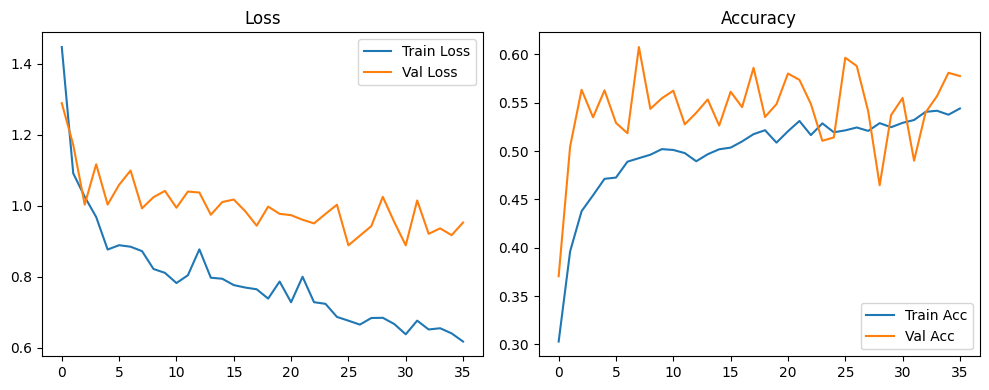

In [11]:
# =========================
# 6. TRAIN THE MODEL
# =========================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Plot training history (optional)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()


Test Accuracy: 59.27%
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
               precision    recall  f1-score   support

       Fatal       0.04      0.37      0.08       195
       Fetal       0.05      0.80      0.09        10
     Serious       0.18      0.39      0.25      1805
      Slight       0.90      0.63      0.74     12025

    accuracy                           0.59     14035
   macro avg       0.29      0.55      0.29     14035
weighted avg       0.79      0.59      0.67     14035



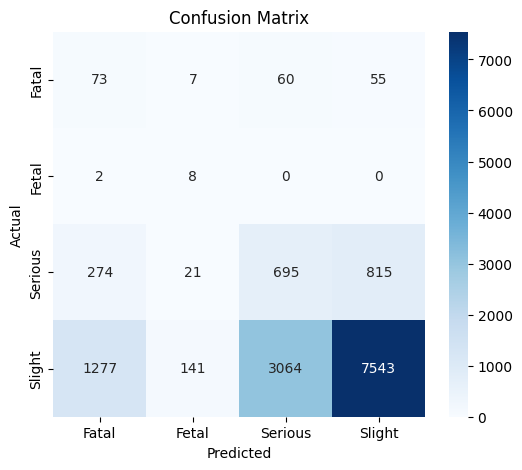

In [12]:
# =========================
# 7. EVALUATE THE MODEL
# =========================

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=le_target.classes_.astype(str)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
# =========================
# 8. SAVE THE MODEL
# =========================

model.save("road_accident_severity_model_improved.h5")
print("Improved model saved successfully!")

Improved model saved successfully!
